# Отток клиентов фитнес-центра

## Описание проекта

Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. 

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты чаще просто перестают пользоваться сервисом тихо. Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. 

**Цель исследования — провести анализ и подготовить план действий по удержанию клиентов.**

Для решения поставленной задачи нужно было:
- спрогнозировать вероятность оттока на уровне следующего месяца для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- разработать рекомендации по повышению качества работы с клиентами:
    - выделить целевые группы клиентов;
    - предложить меры по снижению оттока;
    - определить другие особенности взаимодействия с клиентами.

_____________________


In [1]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [5]:
#количество пропусков
df.isnull().sum()

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

In [6]:
#количество дубликатов
df.duplicated().sum()

0

In [7]:
#перевод названия столбцов в нижний регистр
df.columns = df.columns.str.lower()
df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


**Промежуточный вывод**

В датасете 4000 наблюдений. Пропусков и дубликатов нет. Все форматы данных в норме. Названия столбцов привели к нижнему регистру.
____________

### Исследовательский анализ данных (EDA)

In [8]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


**Промежуточный вывод**

- Среди посетителей примерно одинаково распределено количество мужчин и женщин.
- Большинство посетителей живет или работает рядом с фитнес-центром – 84,5%.
- Чуть менее половины посетителей ходят в фитнес-центр по партнерским программам.
- Треть посетителей впервые пришла по промо-коду от знакомого.
- Большинство клиентов оставили свой номер телефона – 90%.
- В среднем длительность абонемента составляет 4,7 месяцев.
- Групповые занятия посещали 41% клиентов.
- Все клиенты фитнес-клуба совершеннолетние. Средний возраст клиента – 29 лет, +/- 3,3 года.
- В целом на одного клиента приходится 146,9 условных единиц выручки.
- В среднем срок до окончания текущего действующего абонемента клиента – 4,3 месяца.
- В среднем время с момента первого обращения в фитнес-центр на одного клиента – 3,72 месяца.
- Средняя частота посещений клиента в неделю за все время с начала действия абонемента – 1,88 раз, а за предыдущий месяц – 1,77 раз;
- Доля оттока – 26,5%


#### 1. Средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [9]:
#информация о тех, кто ушел в отток
df.query("churn == 1").describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.0
mean,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546,1.0
std,0.500118,0.422217,0.478837,0.387495,0.296204,2.132371,0.443448,2.895163,77.696419,1.964593,1.110799,0.694705,0.770237,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,25.000000,50.629127,1.000000,0.000000,1.010771,0.421337,1.0
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,103.814686,1.000000,1.000000,1.491187,0.979445,1.0
75%,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,29.000000,165.616858,1.000000,1.000000,1.956438,1.588576,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,38.000000,425.535220,12.000000,9.000000,3.478646,3.540271,1.0


**Выводы по тем, кто ушел в отток:**
- Из 4000 клиентов 1061 человек ушло в отток.
- Соотношение полов распределено примерно одинаково.
- Количество людей, живущих или работающих близко в фитнес-центру, – 76,8% клиентов.
- По партнерским программам в фитнес-центр ходят только треть клиентов(35,5%) клиентов.
- 18,4% посетителей впервые пришла по промо-коду от знакомого. 
- Большинство клиентов оставили свой номер телефона – 90%.
- В среднем длительность абонемента составляет 1,7 месяцев.
- Групповые занятия посещали 26,9%.
- Средний возраст клиента – 27 лет.
- В целом на одного клиента приходится 115,1 условных единиц выручки. 
- В среднем срок до окончания текущего действующего абонемента клиента – 1,66 месяца. Те, кто ушел в отток, не брали слишком большой абонемент – 75% пользователей приобрели абонемент на 1 месяц.
- В среднем время с момента первого обращения в фитнес-центр на одного клиента – 1 месяц. Такие клиенты ходят реже, чем другие. 
- Средняя частота посещений клиента в неделю за все время с начала действия абонемента – 1,5 раза, а за предыдущий месяц – 1 раз.

В целом клиенты, прекратившие пользоваться абонементом в фитнес-центр, менее активны: реже приходят по партнерским программам, реже ходят на групповые занятия и в спортзал в целом, меньше покупают дополнительных услуг и продуктов, покупают абонемент на меньший срок (чаще всего на 1 месяц).

Такие демографические признаки, как пол и возраст, в целом совпадают с общими результатами. Но клиенты, которые прекратили ходить в спортзал, в среднем немного моложе. Номер телефона все дают примерно одинаково.

In [10]:
#информация о тех кто остался
df.query("churn == 0").describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.0
mean,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882,0.0
std,0.499984,0.332933,0.498914,0.478144,0.295040,4.716942,0.498795,3.009933,99.801599,4.363522,3.874780,1.016006,1.018994,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,19.000000,0.171862,1.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,28.000000,76.920993,1.000000,2.000000,1.283137,1.297021,0.0
50%,1.000000,1.000000,1.000000,0.000000,1.000000,6.000000,0.000000,30.000000,149.881171,6.000000,4.000000,2.043252,2.046697,0.0
75%,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,32.000000,224.448274,10.000000,6.000000,2.732944,2.740648,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,0.0


**Вывод по тем, кто остался:**

- Среди посетителей примерно одинаково распределено количество мужчин и женщин.
- Большее количество клиентов живет или работает рядом с фитнес-центром – 87,3%.
- Чуть более половины посетителей ходят в фитнес-центр по партнерским программам.
- Чуть меньше половины клиентов впервые пришла по промокоду от знакомого.
- Большинство клиентов оставили свой номер телефона – 90%.
- В среднем длительность абонемента составляет 5,75 месяцев.
- Групповые занятия посещали 46,4% клиентов.
- Средний возраст клиента – почти 30 лет.
- В целом на одного клиента приходится 158,5 условных единиц выручки.
- В среднем срок до окончания текущего действующего абонемента клиента – 5,3 месяца.
- В среднем время с момента первого обращения в фитнес-центр на одного клиента – 4,7 месяца.
- Средняя частота посещений клиента в неделю за все время с начала действия абонемента – 2 раза, столько же и за предыдущий месяц.

В целом в клуб систематически ходят более активные клиенты. Чаще всего они ближе живут, половина из них приходит по партнерским программам и по промокоду от знакомого, покупает абонемент на более долгий срок и чаще посещают групповые занятия. Такие клиенты тратят больше средств на дополнительные услуги в фитнес-центре и в принципе систематически ходят в спортзал в среднем 2 раза в неделю.

Такие клиенты немного старше остальных – им около 30 лет. Соотношение полов примерно одинаковое. Номера телефонов оставляют примерно также, как и остальные.

#### 2. Столбчатые гистограммы и гистограммы распределения признаков для тех, кто ушёл в отток и тех, кто остался.

- Столбчатые гистограммы по бинарным признакам.

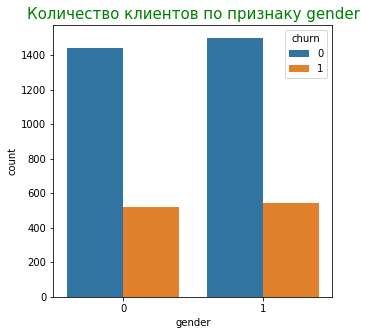

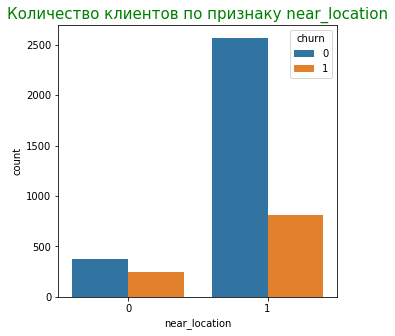

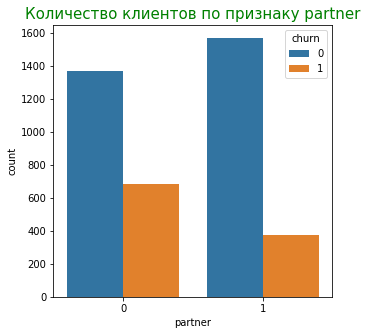

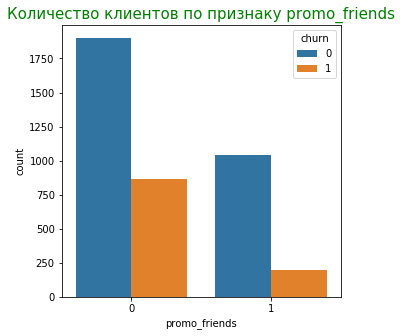

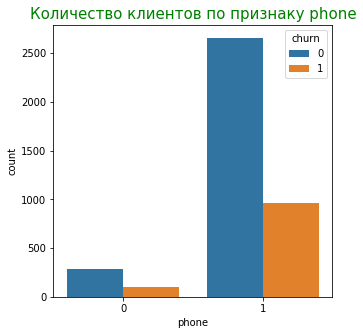

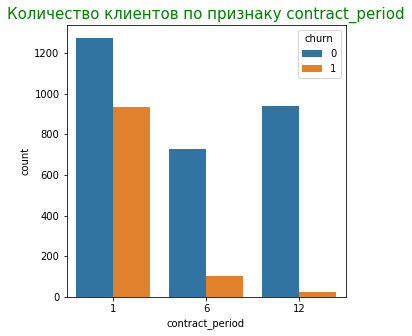

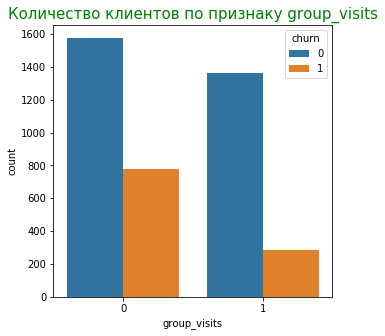

In [11]:
for column in ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits']:
    plt.figure(figsize=(5, 5))
    sns.countplot(x = df[column], hue='churn', data=df)
    plt.title('Количество клиентов по признаку ' +column, fontsize = 15, color = 'g')
    plt.show() 

- График плотности распределения для небинарных признаков.

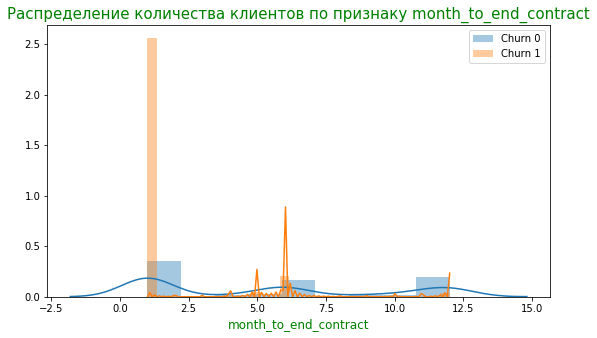

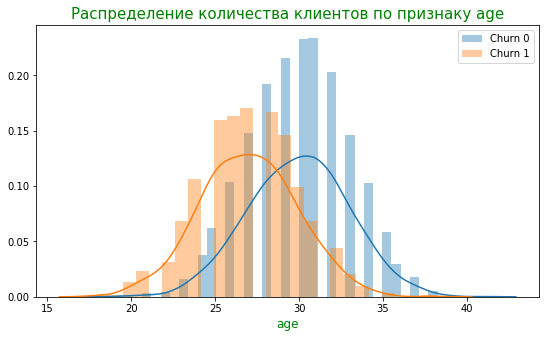

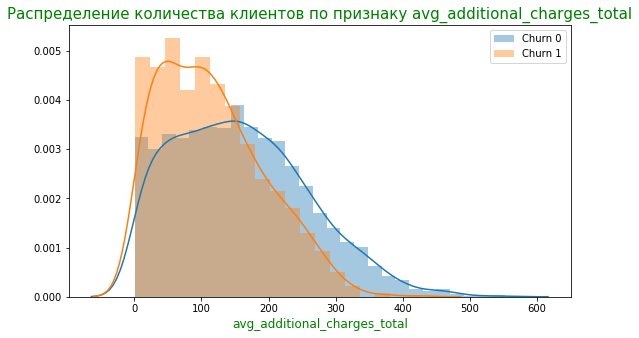

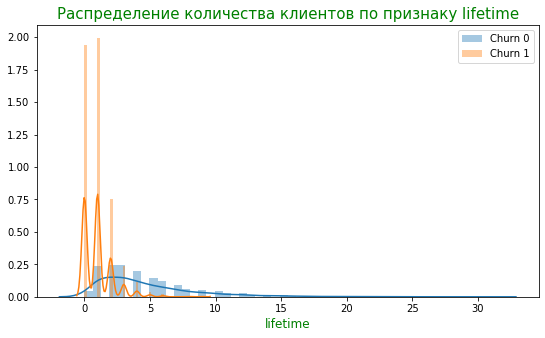

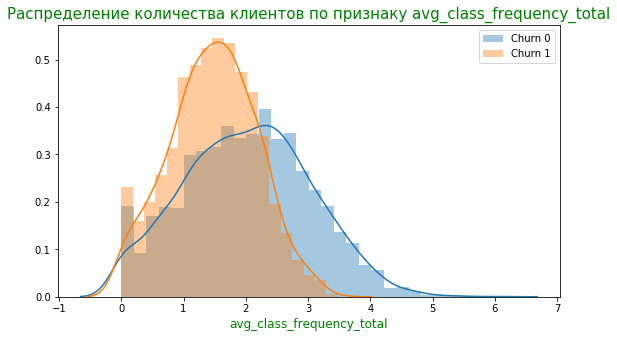

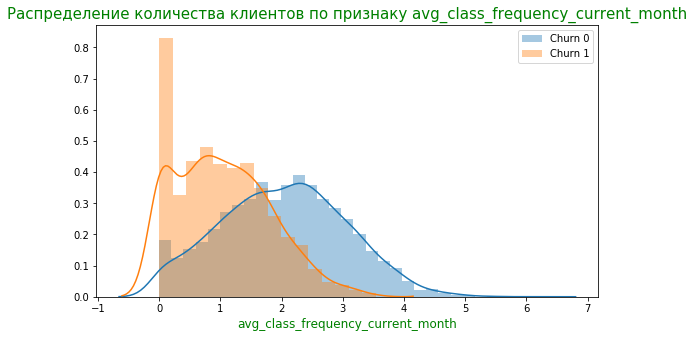

In [13]:
def hist(df):
    #for col in df.columns:
    for col in ['month_to_end_contract', 'age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']:
        if col != 'сhurn':
            plt.figure(figsize = (9,5))
            sns.distplot(df.loc[df['churn']==0, col])
            sns.distplot(df.loc[df['churn']==1, col])
            plt.title('Распределение количества клиентов по признаку '+col, fontsize = 15, color = 'g')
            plt.xlabel(col, fontsize = 12, color = 'g')
            plt.legend(['Churn 0', 'Churn 1'], loc='best')
            
hist(df)

**Промежуточный вывод:**
1. Соотношение полов для тех, кто ушел и тех, кто остался, примерно одинаковое. 
2. Большинство посетителей живет или работает поблизости к расположению фитнес-центра.
3. Люди, которые пришли не по партнерской программе, остаются и попадают в отток в равной степени. Среди тех, кто пришел по партнерской программе, большинство клиентов осталось.
4. Люди, которые пришли не по промокоду от знакомого, остаются и попадают в отток в равной степени. Среди тех, кто пришел по промокоду от знакомого, большинство клиентов осталось.
5. Почти все клиенты предоставили свой номер телефона. 
6. В целом видно, что длительность текущего действующего абонемента в среднем составляет: 1, 6 и 12 месяцев. Чем больше абонемент, тем меньше людей попадало в отток. Большинство клиентов, приобревших абонемент на 1 месяц, отвалилось.
7. Большинство клиентов не посещает групповые занятия – распределение оставшихся и ушедших людей здесь одинаково. Однако те, кто их посещает, уходят реже.
8. В целом клиенты постарше чаще остаются и продолжают ходить в фитнес-центр.
9. Оставшиеся клиенты приносят больше дополнительной выручки, чем те, кто ушел. Возможно из-за более короткого срока посещения, они не успевают воспользоваться всеми дополнительными услугами и продуктами, например, массажем или кафе, и поэтому приобретают что-то реже.
10. Чаще всего до конца абонемента клиентам остался 1, 6 и 12 месяцев. Вероятно, в датасете много новых клиентов, потому что этот период совпадает с длительностью абонементов. Чем больше месяцев осталось до окончания договора, тем меньше людей отваливаются.
11. С момента первого обращения в фитнес-центр в среднем прошло до 6 месяцев. Большинство клиентов отваливаются к третьему месяцу посещения фитнес-центра.
12. Средняя частота посещений в неделю за все время с начала действия абонемента для оставшихся клиентов в разы больше, чем для отвалившихся. Вероятно, те, кто ушел в отток, были не слишком мотивированы заниматься спортом систематически.
13. Большинство их тех, кто ушел в отток, за прошлый месяц посещали фитнес-центр до 2 раз в неделю в среднем. Кто-то вообще не приходил. Большинство из тех, кто остался, в среднем занимались спортом от 1 до 3 раза в неделю.
14. Соотношение тех, кто отвалился, к тем, кто остался, в среднем составляет 1:3.

Можно предположить, что на отток клиентов влияет длительность абонемента, наличие партнерской программы, промокода от знакомого, и активность клиента: общее количество посещений в неделю, посещение групповых занятий, приобретение дополнительных услуг и продуктов. 

#### 3. Матрица корреляций.

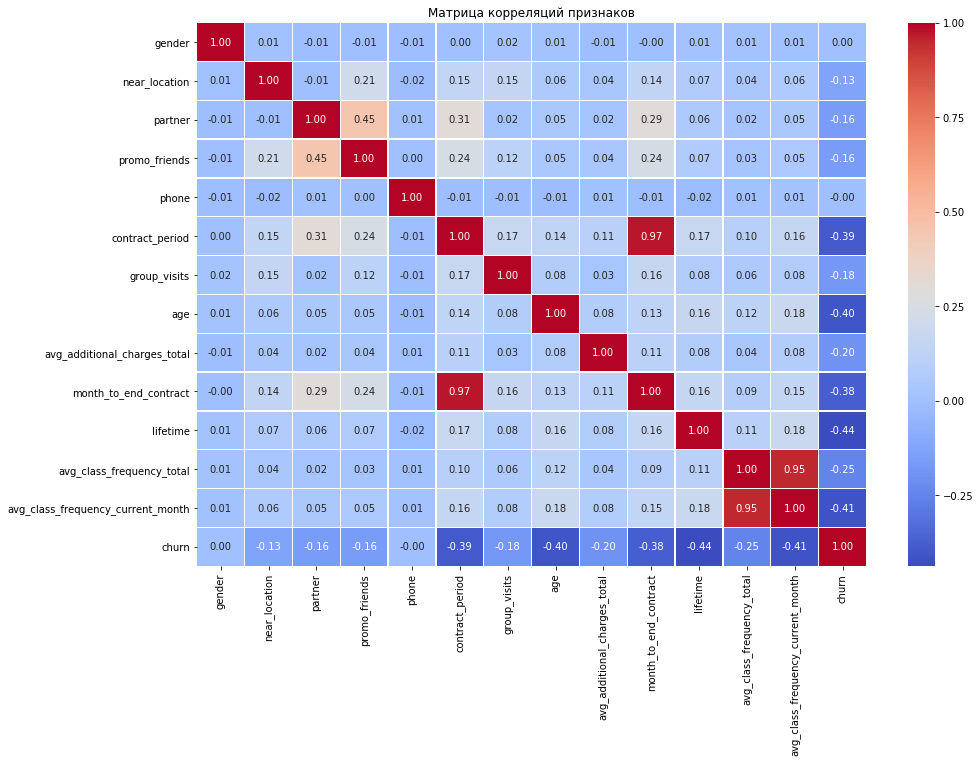

In [14]:
cm = df.corr()
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(cm, annot = True, fmt = '0.2f', linewidths=.3, cmap='coolwarm')
plt.title('Матрица корреляций признаков')
plt.show()

**Промежуточный вывод:**

С целовой переменной особо ничего сильно не коррелирует. На нее же абсолютно не влияют показатели `gender` и `phone`. Выявлены следующие мультиколлинеарные признаки:
1. `contract_period` и `month_to_end_contract`
2. `avg_class_frequency_current_month` и `avg_class_frequency_total`
___________

### Модель прогнозирования оттока клиентов

#### 1. Разбивка данных на обучающую и валидационную выборку функцией train_test_split().

In [15]:
#разделям данные на признаки (матрица X) и целевую переменную (y)
X = df.drop(columns=['churn'])
y = df['churn']

In [16]:
#разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [17]:
#проверим, что классы перемешаны
print(f"Классы в y_train:\n{y_train}")
print(f"Классы в y_test:\n{y_test}")

Классы в y_train:
1161    0
2355    0
1831    0
156     0
195     0
       ..
835     0
3264    0
1653    0
2607    1
2732    0
Name: churn, Length: 3200, dtype: int64
Классы в y_test:
2230    0
668     1
3616    0
2363    1
142     0
       ..
1118    1
3572    0
2482    0
643     0
299     0
Name: churn, Length: 800, dtype: int64


**Промежуточный вывод:**

Разделили модель на обучающиую и валидационную выборку в соотношении 80:20.

#### 2. Обучение модели на train-выборке двумя способами: логистической регрессией, случайным лесом.

In [18]:
#обучаем scaler и трансформируем матрицу для обучающей выборки
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)

In [19]:
#применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)
 
models = [LogisticRegression(random_state=0),RandomForestClassifier(random_state=0)]

In [20]:
#обучаем модель
def print_metrics(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('\tAccuracy: {:.2f} \tPrecision: {:.2f} \tRecall: {:.2f}'.format(accuracy_score(y_test, y_pred),
                                                                          precision_score(y_test, y_pred),
                                                                          recall_score(y_test, y_pred)))

#### 3. Оценка метрик accuracy, precision и recall для обеих моделей на валидационной выборке.

In [21]:
for i in models:
    print(i)
    print_metrics(i, X_train, y_train, X_test, y_test)
    type(models).__name__

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
	Accuracy: 0.93 	Precision: 0.86 	Recall: 0.83
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
	Accuracy: 0.91 	Precision: 0.83 	Recall: 0.78


**Промежуточный вывод:**

На основании метрик accuracy (доля правильных ответов), precision (точность) и recall (полнота) логистическая регрессия (Accuracy: 0.93, Precision: 0.86, Recall: 0.83) показала себя лучше, чем случайный лес (Accuracy: 0.91, Precision: 0.83, Recall: 0.78).

###  Кластеризация клиентов

#### 1. Стандартизация данных.

In [22]:
x_sс = df.drop(['churn'], axis=1)
x_sc_columns_list = x_sс.columns
x_sс = scaler.fit_transform(x_sс)
x_sс = pd.DataFrame(x_sс, columns = x_sc_columns_list).astype('float64')

#### 2. Постройка матрицы расстояний функцией linkage() на стандартизованной матрице признаков.

In [23]:
linked = linkage(x_sс, method = 'ward')

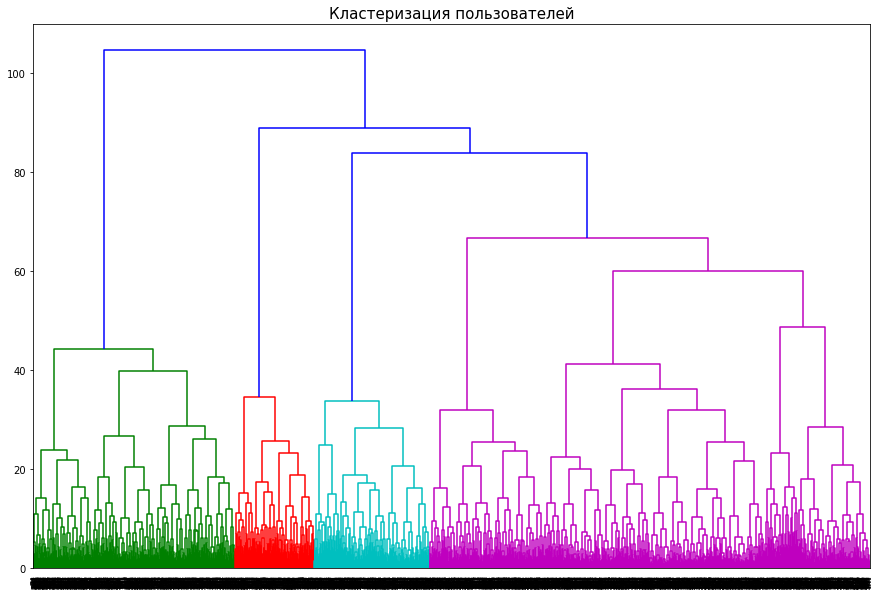

In [24]:
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Кластеризация пользователей', fontsize=15)
plt.show()

**Промежуточный вывод:**

На основании дендрограммы, можно предположить, что клиентов можно разделить на 5 кластеров.

#### 3. Обучение модели кластеризации на основании алгоритма K-Means и прогнозирование кластеров клиентов. 

In [25]:
#задаём число кластеров, равное 5
km = KMeans(n_clusters = 5, random_state = 0)

#применяем алгоритм к данным и формируем вектор кластеров 
labels = km.fit_predict(x_sс)

#сохраняем метки кластера в поле датасета
df['cluster_km'] = labels

#### 4. Средние значения признаков для кластеров.

In [26]:
#количество и процент клиентов в каждом кластере
counts = df['cluster_km'].value_counts()
percent = counts / counts.sum()
fmt = '{:.1%}'.format
pd.DataFrame({'counts': counts, 'percentage': percent.map(fmt)})

,counts,percentage
3,1262,31.6%
0,1011,25.3%
4,837,20.9%
2,505,12.6%
1,385,9.6%


In [27]:
#выводим статистику по средним значениям признаков по кластерам
df.groupby(['cluster_km']).mean().round(2).T

cluster_km,0,1,2,3,4
gender,0.50,0.52,0.50,0.49,0.56
near_location,0.96,0.86,0.00,1.00,0.98
partner,0.78,0.47,0.46,0.35,0.36
promo_friends,0.57,0.31,0.08,0.24,0.23
phone,1.00,0.00,1.00,1.00,1.00
contract_period,10.88,4.79,2.35,1.95,2.67
group_visits,0.54,0.43,0.22,0.34,0.47
age,29.98,29.30,28.48,28.17,30.13
avg_additional_charges_total,160.71,143.96,135.46,131.62,161.72
month_to_end_contract,9.95,4.48,2.20,1.86,2.46


**Кластер 0**

- Почти все клиенты живут/работают близко к фитнес-центру – 96%.
- Чаще остальных приходят по партнерской программе и промокоду от знакомых – 78% и 57% соответственно.
- Самый долгий абонемент среди всех кластеров – 10,88 месяцев. Также самый большой срок до окончания абонемента – 9,95 месяцев в среднем.
- Чаще других кластеров ходят на групповые занятия – 57% клиентов.
- Дают большую дополнительную вырочку – 160,74 у.е. на клиента.
- Один из самых больших значений время и с момента первого обращения в фитнес-центр – 4,74 мес.
- Посещают фитнес-центр в среднем 2 раза в неделю.
- **Самый низкий показатель оттока – 3%.**
- **Второй кластер по количеству принадлежности к нему людей – 1011 клиентов (25.3% от общего числа).**

**Кластер 1**

- Живут/работаю близко к фитнес-центру 86% клиентов.
- В половине случаев приходят по партнерской программе, в трети случаев – по промокоду от знакомого.
- Чаще не указывают номер телефона.
- Оформляют абонемент на 4,8 месяцев. До конца абонемента в среднем 4,5 месяца.
- 43% клиентов посещают групповые занятия.
- Сумма доп. выручки на клиента – 143,96 у.е.
- В среднем посещают фитнес-центр от 1,72 до 1,85 раз в неделю.
- 27% клиентов попадают в отток.
- В этом кластере меньше всего людей – 385 клиентов (9.6% от общего числа).

**Кластер 2**

- Клиенты живут далеко от фитнес-центра.
- В половине случаев приходят по партнерской программе, почти не приходят по промокоду от знакомого.
- В среднем продолжительность абонемента составляет 2,35 месяца. До конца абонемента в среднем 2,2 месяца.
- Меньше всего посещают групповые занятия – всего 22% клиентов кластера.
- Клиенты кластера приносят не очень много доп. выручки – 135,46 у.е. на клиента.
- Средняя "продолжительность жизни" клиента – 1,66 мес.
- **Один из самых высоких показателей оттока – 44%.**
- В этом кластере 505 посетителей (12.6% от общего числа)

**Кластер 3**

- Все клиенты кластера живут или работают рядом с фитнес-центром.
- Количество клиентов, приходящих по партнерским программам, – 35%, по промокоду – 24%. Это одни из самых низких показателей среди всех кластеров.
- Самый низкий период длительности абонемента – 1,95 месяцев.
- Треть клиентов кластера ходят на групповые занятия.
- Приносят меньше всех доп. выручки – 131,62 у.е. на клиента.
- В среднем посещают фитнес-центр от 1 до 1,25 раз в неделю.
- **Самый высокий показатель оттока – 51%.**
- **В этом кластере больше всего посетителей – 1262 клиентов (31.6% от общего числа).**

**Кластер 4**

- Почти все клиенты проживают или работают рядом с фитнес-центром.
- Количество клиентов, приходящих по партнерским программам, – 36%, по промокоду – 23%. Это одни из самых низких показателей среди всех кластеров.
- В среднем возраст клиента выше остальных – 30,13 лет.
- Клиенты приносят больше всех дополнительную выручку – 161,72 у.е.
- В среднем посещают фитнес-центр 2,85 раз в неделю.
- **Один из самых низких показателей оттока – 7%.**
- **В этом кластере 837 посетителей (20.9% от общего числа).**

#### 5. Распределения признаков для кластеров.

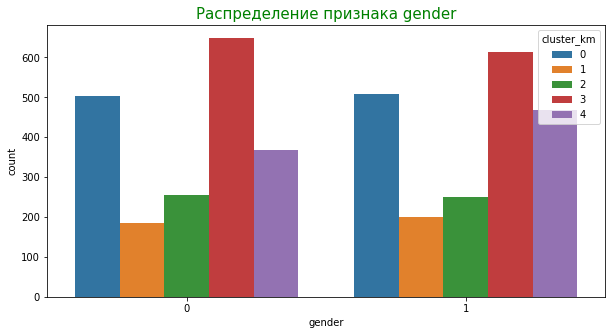

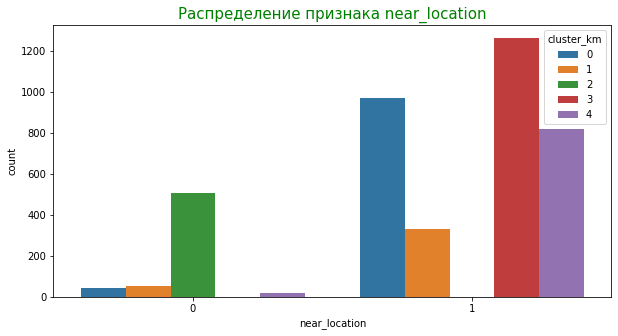

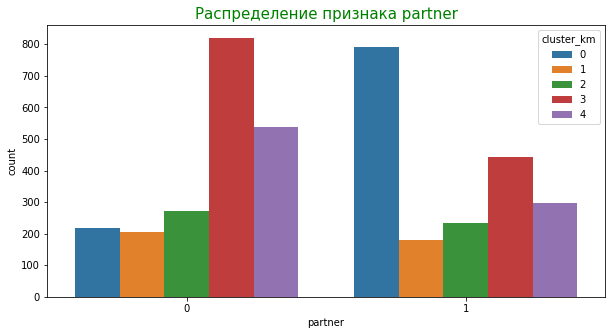

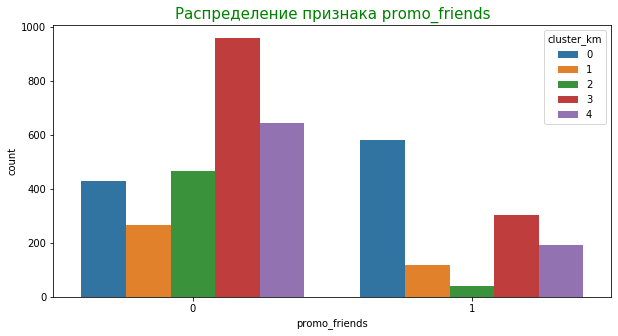

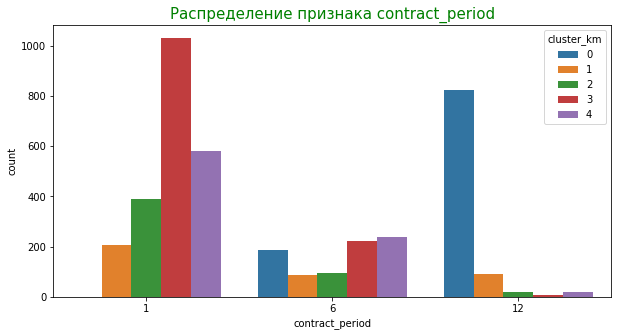

In [28]:
for column in ['gender', 'near_location', 'partner', 'promo_friends', 'contract_period']:
    plt.figure(figsize=(10, 5))
    sns.countplot(x = df[column], hue='cluster_km', data=df)
    plt.title('Распределение признака ' +column, fontsize = 15, color = 'g')
    plt.show()  

- Распределение по полу во всех кластерах примерно равномерно. В кластере 4 количество клиентов пола 1 чуть больше, чем пола 0.
- Все кластеры, кроме второго, живут или работают поблизости от фитнес-центра.
- Клиенты почти все кластера 0, чуть более половины кластеров 1 и 2 пользуются партнерскими программами, в то время как клиенты кластера 3 и 4 по большей части нет.
- В целом небольшой процент от всех класторов пользуются промокодом от знакомых, кроме кластера 0. 
- Самый частый абонемент для всех кластеров – 1 месяц, кроме кластера 0, его клиенты чаще всего покупают абонемент на 12 месяцев.


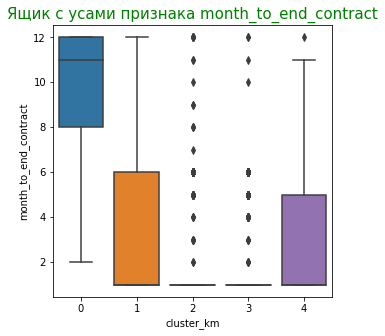

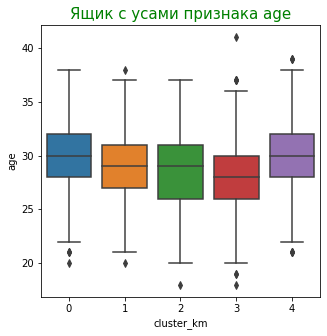

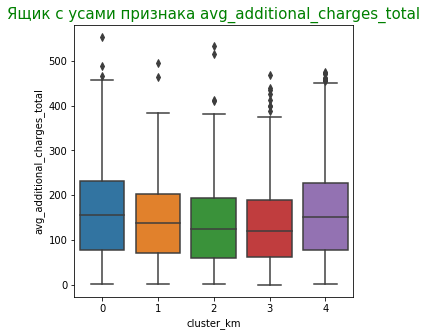

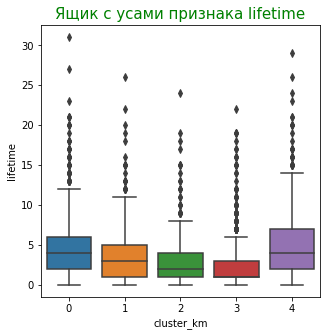

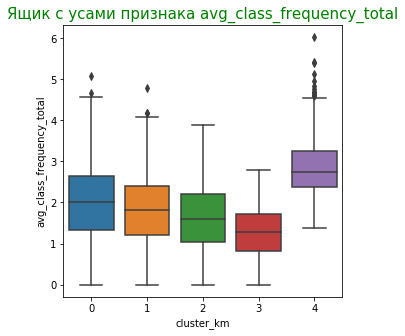

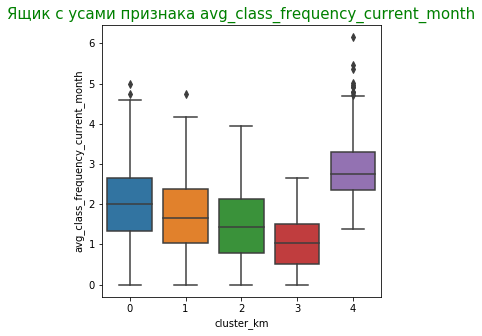

In [29]:
for column in ['month_to_end_contract', 'age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']:
    plt.figure(figsize=(5, 5))
    sns.boxplot(x = 'cluster_km', y = df[column], data = df)
    plt.title('Ящик с усами признака ' +column, fontsize = 15, color = 'g')
    plt.show()

- У клиентов кластера 0 самое большое количество месяцев до окончания абонемента. Для кластера 1 и 4 в среднем осталось 6 и 5 месяцев соответственно. У кластеров 2 и 3 осталось минимальное количество месяцев, за исключением некоторых клиентов.
- Возраст в кластерах примерно одинаковый – от 27 до 33 лет. Кластер 3 самый "молодой", а 0 и 4 – самые "взрослые".
- Больше всего выручки приносят кластеры 0 и 4. Они платят больше, по сравнению с другими кластерами.
- В целом самая продолжительное время пользованием абонементов у кластеров 4 и 0. У третьего кластера – самый недолгий срок.
- Больше всего посещений в неделю совершают клиенты кластера 4. Данные за прошедший месяц в целом совпадают с ежемесячными посещениями. 

#### 6.  Доля оттока для каждого полученного кластера.

In [30]:
df.groupby(['cluster_km']).mean().T

cluster_km,0,1,2,3,4
gender,0.502473,0.522078,0.495050,0.485737,0.560335
near_location,0.959446,0.862338,0.000000,1.000000,0.976105
partner,0.783383,0.470130,0.463366,0.350238,0.356033
promo_friends,0.574679,0.306494,0.079208,0.240095,0.229391
phone,1.000000,0.000000,1.000000,1.000000,0.998805
contract_period,10.884273,4.787013,2.352475,1.948494,2.665472
group_visits,0.543027,0.425974,0.215842,0.341521,0.473118
age,29.980218,29.301299,28.477228,28.167987,30.127838
avg_additional_charges_total,160.706969,143.957664,135.457501,131.622204,161.724258
month_to_end_contract,9.950544,4.475325,2.198020,1.856577,2.455197


**Промежуточный вывод:**

Кластеры 3 и 2 больше всех склонны к оттоку. Менее всех – кластеры 0 и 4.
_________

### Выводы

В датасете 4000 наблюдений. Пропусков и дубликатов нет. Все форматы данных в норме. В целом выгрузка хорошая и хочется отдельно похвалить тех, кто ее делал.

Проект отражает поведение клиентов при посещении фитнес-центра (среднее количество посещений в неделю, дополнительные траты в центре), информацию о них самих (пол, возраст, близость к фитнес-центру, участие в партнерских программах и использование промокодов от знакомых и др.) и их отток.

В целом в клуб систематически ходят более активные клиенты. Чаще всего они ближе живут, половина из них приходит по партнерским программам и по промокоду от знакомого, покупает абонемент на более долгий срок и чаще посещают групповые занятия. Такие клиенты тратят больше средств на дополнительные услуги в фитнес-центре и в принципе систематически ходят в спортзал (в среднем 2 раза в неделю). Такие клиенты немного старше остальных – им около 30 лет.

Клиенты, прекратившие пользоваться абонементом в фитнес-центр, менее активны: реже приходят по партнерским программам, реже ходят на групповые занятия и в спортзал в целом, меньше покупают дополнительных услуг и продуктов, покупают абонемент на меньший срок (чаще всего на 1 месяц).
__________________   
   
Проведен корреляционный анализ всех показателей. С показателем оттока особо ничего сильно не коррелирует. На нее же абсолютно не влияют показатели gender и phone. Выявлены мультиколлинеарные признаки.
   
Была обучена модель двумя способами: логистической регрессией и случайным лесом. На основании метрик accuracy (доля правильных ответов), precision (точность) и recall (полнота) логистическая регрессия (Accuracy: 0.93, Precision: 0.86, Recall: 0.83) показала себя лучше, чем случайный лес (Accuracy: 0.91, Precision: 0.83, Recall: 0.78).

**Провели кластеризацию клиентов и разбили их на 5 классов:**

#### Кластер 0. 

В кластер попало 25,3% всех клиентов датасета. Почти все клиенты близко живут или работают к фитнес-центру и достаточно лояльны к нему: пользуются партнерскими программами, промокодами от знакомых, покупают продолжительные абонементы, ходят в спортзал в среднем 2 раза в неделю. Клиенты этого кластера мало того, что приносят почти самую большую дополнительную выручку на одного посетителя, так и имеют **самый низкий показатель оттока – 3%.**

#### Кластер 1.

Кластер включает в себя самое малое количество клиентов – 385 человек (9,6% от общего числа). Они реже пользуются партнерскими программами, промокодами от друзей, часто не указывают не дают номер телефона. Приобретают абонемент на 4,5 месяца. **27% клиентов этого кластера попадают в отток.**

#### Кластер 2.

В этот кластер попало 505 посетителей (12,6% от общего числа). Они еще реже пользуются партнерской программой и почти не приходят по промокоду от знакомого, меньше всех посещают групповые занятия и приносят немного дополнительной выручки. У них небольшая средняя "продолжительность жизни" клиента и **один из самых высоких показателей оттока – 44%.**

#### Кластер 3.

Это самый большой по количеству клиентов кластер – 1262 посетителя (31.6% от общего числа). Они почти не пользуются партнерской программой и не приходят по промокоду от знакомого, треть клиентов посещает групповые занятия. Приносят меньше всего дополнительной выручки и посещают фитнец-центр 1,25 раз в неделю. У этого кластера **самый высокий показатель оттока – 51%, т.е. половина кластера просто уходят.**

#### Кластер 4

В этот кластер входят 837 посетителей (20.9% от общего числа). Они живут или работают достаточно близко к фитнес-центру, но не особо пользуются партнерскими программами и промокодами от знакомых. Эти клиенты приносят больше всех дополнительную выручку и ходят 2,85 раз в неделю. У них достаточно низкий **показатель оттока – всего 7%.**


Предпочтительнее продолжить работать с кластерами 4 и 0, а работу с кластерами 2 и 3 точно нужно пересмотреть.
___________







### Рекомендации для стратегии взаимодействия с клиентами и их удержания.
1. Привлечь больше людей, живущих или работающих поблизости от фитнес-центра, например, с помощью рекламной кампании в интернете или наружной рекламы.
2. Привлечь больше партнеров для предоставления их сотрудникам скидки на абонемент и, как следствие, больше новых клиентов.
3. При заключении договора с новым клиентом, делать больший упор на длительные абонементы. Так посетители ходят чаще, приносят больше дополнительной выручки и реже попадают в отток. Возможно стоит сделать на эти абонементы скидки для привлечения большего количества людей. 
4. Напоминать почаще и привлекать клиентов на групповые занятия, например, с помощью sms- и email рассылки. Поскольку они проходят систематически, клиент реже будет попадать в отток и пропадать. Возможно стоит пересмотреть выбор групповых занятий: убрать непопулярные занятия или добавить новых, чтобы клиенту было из чего выбирать и он смог "привыкнуть" на них ходить :)